## Generating Digit Images with a Variational Autoencoder


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch04_AE/ec04_1_denoising/denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [7]:
# !pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

This notebook provides you with a complete code example that
trains a variational autoencoder on the MNIST digits and uses it to generated
new digit images and cluster the digits in the latent space.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 4-A from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the MNIST Dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

Import the MNIST dataset ...

In [8]:
import os
import deeptrack as dt

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

data_dir = os.path.join("MNIST_dataset", "mnist")
train_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "train"))
test_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "test"))
files = dt.sources.Join(train_files, test_files)

print(f"Number of train images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

Cloning into 'MNIST_dataset'...
Updating files: 100% (70003/70003), done.


Number of train images: 60000
Number of test images: 10000


... create an image pipeline.

In [9]:
import torch

image_pip = (dt.LoadImage(files.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float))

## Training the Variational Autoencoder

Define the variational autoencoder ...

In [10]:
import deeplay as dl

vae = dl.VariationalAutoEncoder(
    latent_dim=2, channels=[32, 64],
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"), beta=1,
).create()

print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
  (fc_var): Linear(in_features=3136, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=3136, bias=True)
  (decoder): ConvolutionalDecoder2d(
    (bl

... define the train dataset and data loader ...

In [11]:
train_dataset = dt.pytorch.Dataset(image_pip & image_pip, inputs=train_files)
train_loader = dl.DataLoader(train_dataset, batch_size=64, shuffle=True)

... and train the variational autoencoder ...

In [12]:
vae_trainer = dl.Trainer(max_epochs=10, accelerator="auto")
vae_trainer.fit(vae, train_loader)

┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                ┃ Type                   ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ encoder             │ ConvolutionalEncoder2d │ 55.7 K │ train │
│ 1 │ fc_mu               │ Linear                 │  6.3 K │ train │
│ 2 │ fc_var              │ Linear                 │  6.3 K │ train │
│ 3 │ fc_dec              │ Linear                 │  9.4 K │ train │
│ 4 │ decoder             │ ConvolutionalDecoder2d │ 76.3 K │ train │
│ 5 │ reconstruction_loss │ BCELoss                │      0 │ train │
│ 6 │ train_metrics       │ MetricCollection       │      0 │ train │
│ 7 │ val_metrics         │ MetricCollection       │      0 │ train │
│ 8 │ test_metrics        │ MetricCollection       │      0 │ train │
│ 9 │ optimizer           │ Adam                   │      0 │ train │
└───┴─────────────────────┴────────────────────────┴────────┴───────┘

Trainable params: 153 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 153 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 36                                                                                          
Modules in eval mode: 0

Output()

## Generating Digit Images with the Decoder

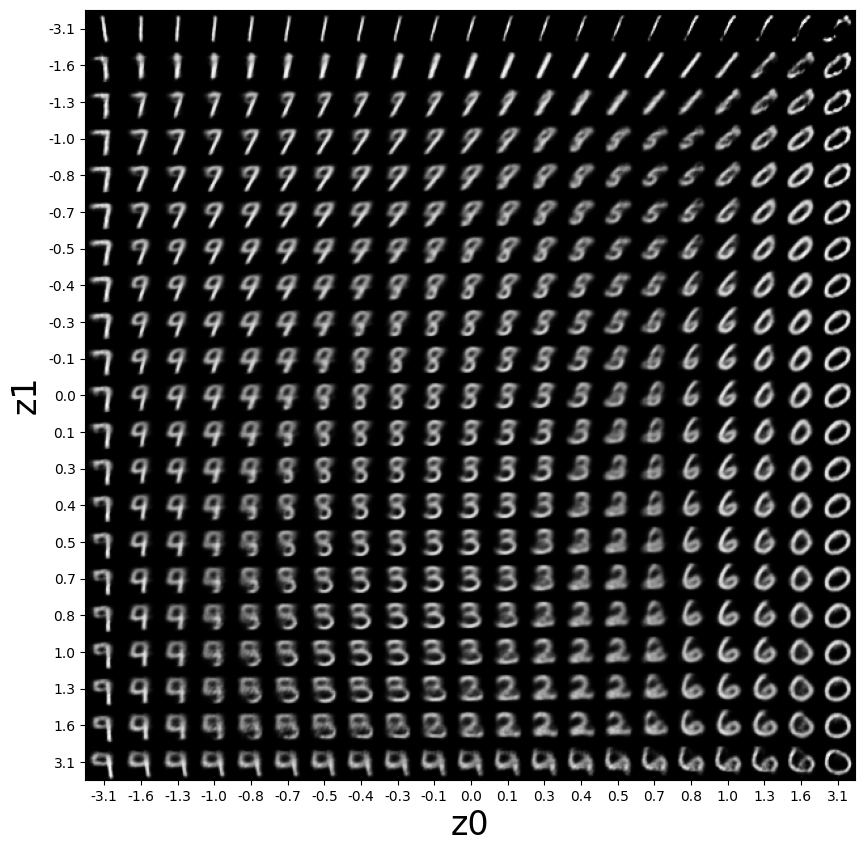

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal

img_num, img_size = 21, 28
z0_grid = z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
      z = torch.stack((z0, z1)).unsqueeze(0)
      generated_image = vae.decode(z).clone().detach()
      image[i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size] = \
          generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xlabel("z0", fontsize=24)
plt.xticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z0_grid.numpy(), 1))
plt.ylabel("z1", fontsize=24)
plt.yticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z1_grid.numpy(), 1))
plt.show()

## Clustering the Digit Images in the Latent Space with the Encoder

Define a pipeline combining the test images and their digit values (labels) ...

In [14]:
label_pip = dt.Value(files.label_name[0]) >> int
test_dataset = dt.pytorch.Dataset(image_pip & label_pip, inputs=test_files)
test_loader = dl.DataLoader(test_dataset, batch_size=64, shuffle=False)

... encode the test images in the latent space ...

In [15]:
mu_list, test_labels = [], []
for image, label in test_loader:
    mu, _ = vae.encode(image)
    mu_list.append(mu)
    test_labels.append(label)
mu_array = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

... plot the latent space.

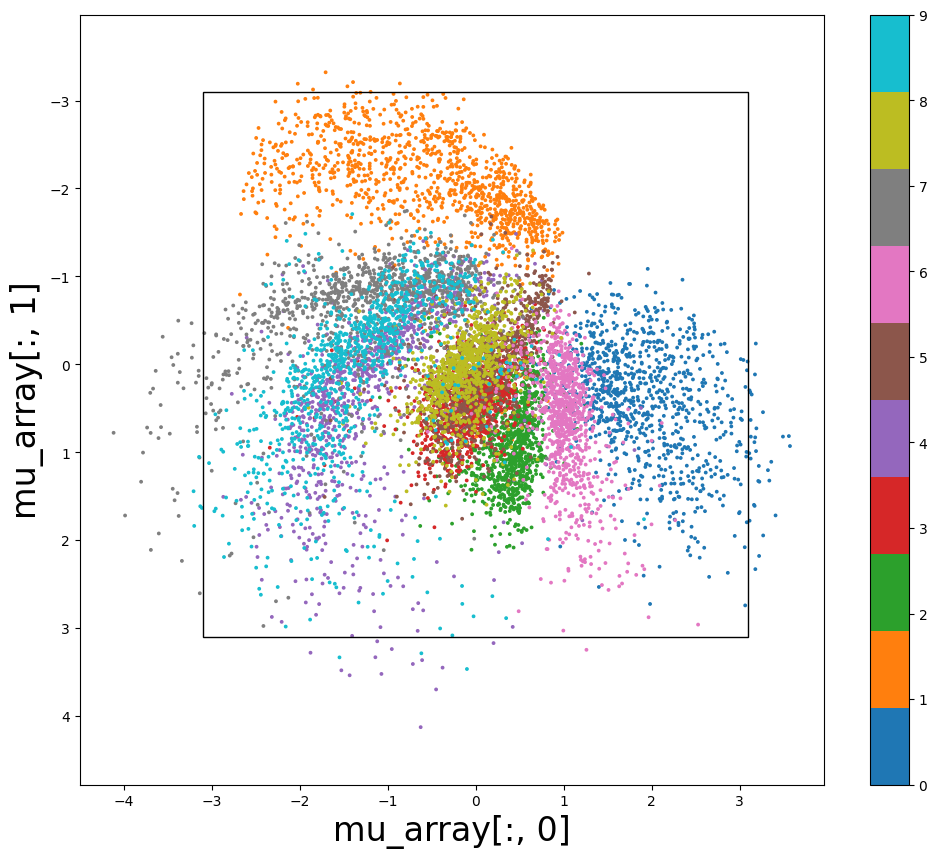

In [16]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
plt.scatter(mu_array[:, 0], mu_array[:, 1], s=3, c=test_labels, cmap="tab10")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.xlabel("mu_array[:, 0]", fontsize=24)
plt.ylabel("mu_array[:, 1]", fontsize=24)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.colorbar()
plt.show()